<img src="./IMTA.png" alt="Logo IMT Atlantique" width="300"/>

##  **Frugal AI : Data Scarcity on Prostate MRI**
## TAF Health - UE B - 2025/2026 

Pierre-Henri.Conze@imt-atlantique.fr - Vincent.Jaouen@imt-atlantique.fr


In this lab, we will work with the **Prostate158** dataset (Mid-Axial slices). 
We want to understand the impact of **training data size** and **augmentation** on segmentation performance.

**Dataset**:
*   Images: T2-weighted MRI slices of the prostate-
*   Labels: Prostate segmentation masks.

**Plan:**
1.  **Setup**: Load `prostate158` dataset and define a fixed validation split.
2.  **Part I (Scarcity)**: Train specific U-Nets on very small subsets (e.g., 5, 10, 20 images) without augmentation.
3.  **Part II (Augmentation)**: Repeat the training on the smallest subsets using extensive Data Augmentation.
4.  **Analysis**: Compare learning curves and final Dice scores.

In [1]:
# Setup for Google Colab
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

if IN_COLAB:
    import os
    print("Running on Google Colab. Installing dependencies...")
    
    # 1. Install necessary libraries
    !pip install -q 'monai[nibabel, tqdm]'
    !pip install -q matplotlib pyyaml
    
    # 2. Clone the repository to access data and utilities
    repo_name = "HealthLabs-IMTA"
    repo_url = "https://github.com/vhxjaouen/HealthLabs-IMTA.git"

    # Check if we are already in the repository (e.g. after a restart)
    current_path = os.getcwd()
    if os.path.basename(current_path) == "notebooks" and os.path.basename(os.path.dirname(current_path)) == repo_name:
        print(f"Already in the repository: {current_path}")
    else:
        # Clone if strictly necessary
        if not os.path.exists(repo_name):
            print(f"Cloning repository {repo_name}...")
            !git clone {repo_url}
        
        # Change working directory to the notebooks folder
        target_dir = os.path.join(repo_name, "notebooks")
        if os.path.exists(target_dir):
            os.chdir(target_dir)
            print(f"Changed working directory to {os.getcwd()}")
            
            # Avoid confusion: remove the duplicate notebook from the cloned repository
            colab_notebook_name = "04_frugalAI_colab.ipynb"
            if os.path.exists(colab_notebook_name):
                os.remove(colab_notebook_name)
                print(f"Removed duplicate notebook {colab_notebook_name} from cloned repo to avoid version confusion.")
        else:
            print("Warning: Could not find notebooks directory. Please check the repository structure.")
            
    print("Dependencies installed and environment set up.")
else:
    print("Running locally.")

import torch
if torch.cuda.is_available():
    print(f"GPU is available: {torch.cuda.get_device_name(0)}")
else:
    print("WARNING: No GPU detected. Training will be very slow.")

Running locally.
GPU is available: NVIDIA GeForce RTX 3090


In [2]:
import sys, os
# sys.path.append(os.path.abspath("..")) # Removed as we use the installed package now
import torch
import glob
import json
import numpy as np
import matplotlib.pyplot as plt
import yaml
from monai.data import CacheDataset, DataLoader
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, ScaleIntensityRangePercentilesd,
    RandFlipd, RandRotate90d, RandZoomd, RandShiftIntensityd, RandGaussianNoised,
    EnsureTyped, SpatialPadd, CenterSpatialCropd, Resized
)
from monai.utils import set_determinism

# Fix seed for reproducibility
set_determinism(seed=29200)

<frozen importlib._bootstrap_external>:1301: FutureWarning: The cuda.cudart module is deprecated and will be removed in a future release, please switch to use the cuda.bindings.runtime module instead.


## 1. Data Loading

We will parse the `dataset.json` provided with the dataset to get image/label pairs.

In [3]:
# Configuration
data_dir = "../datasets/prostate158_MidAxial"
json_path = os.path.join(data_dir, "dataset.json")

# Load dataset.json
with open(json_path) as f:
    schema = json.load(f)

# Extract training paths (relative paths in JSON need to be joined with data_dir)
data_dicts = []
for entry in schema["training"]:
    # json entries: "./imagesTr/xxx.nii.gz"
    img_path = os.path.join(data_dir, entry["image"].replace("./", ""))
    lbl_path = os.path.join(data_dir, entry["label"].replace("./", ""))
    data_dicts.append({"image": img_path, "label": lbl_path})

print(f"Total available images: {len(data_dicts)}")

# Check one pair
print(f"Sample Image: {data_dicts[0]['image']}")

# Define Fixed Split (Last 30 for Validation)
val_size = 30
val_files = data_dicts[-val_size:]
train_pool = data_dicts[:-val_size]

print(f"Validation set size: {len(val_files)}")
print(f"Training pool size: {len(train_pool)}")

Total available images: 139
Sample Image: ../datasets/prostate158_MidAxial/imagesTr/020.nii.gz
Validation set size: 30
Training pool size: 109


## 2. Transforms Pipeline

We setup the MONAI transforms.
*   **Preprocessing**: Load, Channel First, Normalize Intensity (1st-99th percentile).
*   **Augmentation**: Flips, Rotation, Zoom, Intensity Shift (activated only if `augment=True`).

In [4]:
def get_transforms(augment=False):
    # Base Transforms
    transforms_list = [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"], channel_dim=-1), 
        Resized(keys=["image", "label"], spatial_size=(256, 256), mode=("bilinear", "nearest")),
        ScaleIntensityRangePercentilesd(
            keys="image", lower=1, upper=99, 
            b_min=0.0, b_max=1.0, clip=True
        ),
        EnsureTyped(keys=["image", "label"]),
    ]
    
    # Augmentation
    if augment:
        transforms_list += [
            # Geometric
            # Vertical Flip (Axis 1) is anatomically more plausible than L/R or random rotation here
            RandFlipd(keys=["image", "label"], spatial_axis=1, prob=0.5), 
            RandZoomd(keys=["image", "label"], min_zoom=0.9, max_zoom=1.1, mode=["area", "nearest"], prob=0.3),
            
            # Intensity
            RandShiftIntensityd(keys=["image"], offsets=0.1, prob=0.5),
            RandGaussianNoised(keys=["image"], prob=0.1, mean=0.0, std=0.05),
        ]
        
    return Compose(transforms_list)

## 3. Experiment Runner

We reuse the configuration from `segmentation.yaml` but override channel settings.

In [5]:
from healthlabs_imta.utils.training import train_segmentation
from healthlabs_imta.utils.model_utils import model_factory
from monai.losses import DiceCELoss
from monai.metrics import DiceMetric

# Load Config
# import pkg_resources
# Try to load from installed package or fallback to relative path?
# For simplicity, we can use the package structure if data is included, but config yaml is data.
# The user kept data handling as "Keep datasets at root" but configs moved to package.
# So we should load config from the package path.
import os
import healthlabs_imta
package_dir = os.path.dirname(healthlabs_imta.__file__)
config_path = os.path.join(package_dir, "configs", "segmentation.yaml")

with open(config_path) as f:
    cfg = yaml.safe_load(f)

# Override config for this dataset
cfg["data"]["data_dir"] = data_dir
cfg["model"]["in_channels"] = 1   # Single channel MRI
cfg["model"]["out_channels"] = 1  # Binary segmentation
cfg["training"]["max_epochs"] = 30  # Set global default duration

def run_experiment(n_train_samples, augment, max_epochs=None):
    # Use config value if max_epochs not provided
    if max_epochs is None:
        max_epochs = cfg["training"]["max_epochs"]

    print(f"\n{'='*40}")
    print(f"Running Experiment: N={n_train_samples}, Augmentation={augment}, Epochs={max_epochs}")
    print(f"{'='*40}")
    
    # 1. Deterministic Subset
    train_subset = train_pool[:n_train_samples]
    
    # 2. Dataloaders
    train_ds = CacheDataset(
        data=train_subset, 
        transform=get_transforms(augment=augment), 
        cache_rate=1.0, num_workers=2
    )
    val_ds = CacheDataset(
        data=val_files, 
        transform=get_transforms(augment=False), 
        cache_rate=1.0, num_workers=2
    )
    
    train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=2)
    
    # 3. Model Setup
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model_factory(cfg["model"]).to(device)
    loss_fn = DiceCELoss(sigmoid=True, to_onehot_y=False)
    dice_metric = DiceMetric(include_background=True, reduction="mean")
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    
    # 4. Training
    history = train_segmentation(
        model, train_loader, val_loader,
        loss_fn, dice_metric, optimizer,
        device=device, max_epochs=max_epochs,
        overlay_fn=None # Disable plotting during loop
    )
    
    return history, model

/home/jet/venvs/python3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 4. Part I: Scarcity Impact (No Augmentation)

Train with **5, 10, 40** images.

In [6]:
results_no_aug = {}
sample_sizes = [100,50,20]

for n in sample_sizes:
    # We use 50 epochs for a fair comparison with the augmentation part
    (train_losses, val_dices, best_dice, weights), _ = run_experiment(n, augment=False, max_epochs=50)
    results_no_aug[n] = val_dices
    print(f"-> Final Best Dice (N={n}, No Aug): {best_dice:.4f}")


Running Experiment: N=100, Augmentation=False, Epochs=50


Training: 100%|██████████| 50/50 [00:42<00:00,  1.16it/s, loss=0.0637, dice=0.8773]


-> Final Best Dice (N=100, No Aug): 0.8798

Running Experiment: N=50, Augmentation=False, Epochs=50


Training: 100%|██████████| 50/50 [00:33<00:00,  1.48it/s, loss=0.3408, dice=0.8231]


-> Final Best Dice (N=50, No Aug): 0.8243

Running Experiment: N=20, Augmentation=False, Epochs=50


Training: 100%|██████████| 50/50 [00:27<00:00,  1.85it/s, loss=0.9220, dice=0.6940]

-> Final Best Dice (N=20, No Aug): 0.7001


In [8]:
results_aug = {}
aug_sample_sizes = [50,20]

for n in aug_sample_sizes:
    (train_losses, val_dices, best_dice, weights), _ = run_experiment(n, augment=True, max_epochs=50)
    results_aug[n] = val_dices
    print(f"-> Final Best Dice (N={n}, Aug): {best_dice:.4f}")


Running Experiment: N=50, Augmentation=True, Epochs=50


Training: 100%|██████████| 50/50 [00:36<00:00,  1.36it/s, loss=0.3370, dice=0.8800]


-> Final Best Dice (N=50, Aug): 0.8856

Running Experiment: N=20, Augmentation=True, Epochs=50


Training: 100%|██████████| 50/50 [00:29<00:00,  1.67it/s, loss=0.8162, dice=0.8246]

-> Final Best Dice (N=20, Aug): 0.8283


## 6. Analysis and Visualization

Compare the validation Dice curves.

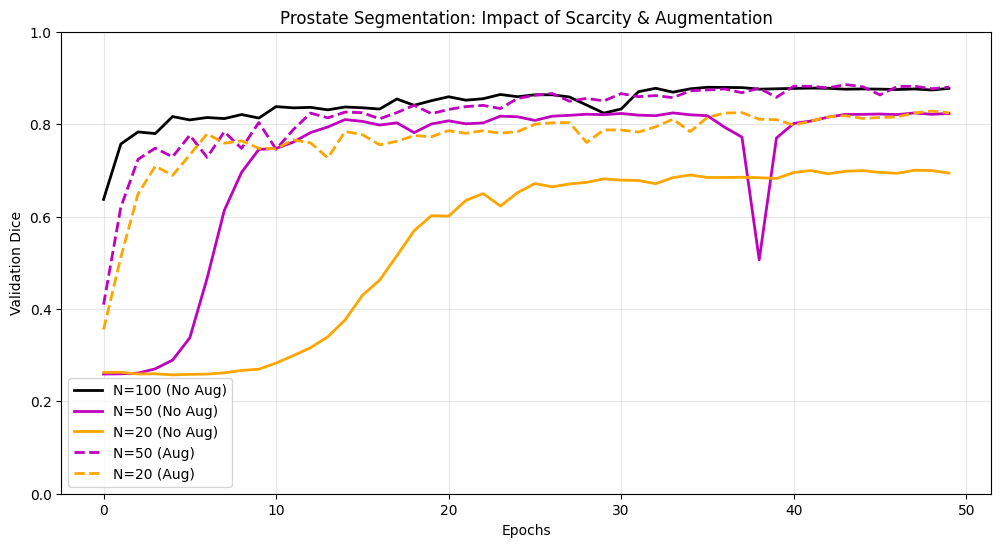

In [9]:
plt.figure(figsize=(12, 6))

colors = {5: 'r', 10: 'g', 20: 'orange', 40: 'b', 50: 'm', 100: 'k'} # Adjusted colors

# Plot No Aug
for n, dices in results_no_aug.items():
    c = colors.get(n, 'gray') # Gray fallback if size not in dict
    plt.plot(dices, label=f'N={n} (No Aug)', color=c, linestyle='-', linewidth=2)

# Plot Aug
for n, dices in results_aug.items():
    c = colors.get(n, 'gray')
    plt.plot(dices, label=f'N={n} (Aug)', color=c, linestyle='--', linewidth=2)

plt.title("Prostate Segmentation: Impact of Scarcity & Augmentation")
plt.xlabel("Epochs")
plt.ylabel("Validation Dice")
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(0, 1.0)
plt.show()


## 7. Part III: Semi-Supervised Learning (Student-Teacher)

We simulate a scenario where we have **100 images** available, but only **50 are labeled**.
Can we leverage the 50 "unlabeled" images to improve the performance of a model trained on only 50 labeled examples?

**Strategy (Self-Training / Pseudo-Labeling):**
1.  **Train Teacher**: Use the 50 labeled images to train a model (Teacher).
2.  **Generate Pseudo-Labels**: Use the Teacher to predict segmentation masks for the 50 unlabeled images.
3.  **Train Student**: Train a new model (Student) on the **combined dataset** (50 Labeled + 50 Pseudo-Labeled).
4.  **Compare**: Student performance vs. Teacher (N=50) vs. Oracle (N=100 Labeled).


In [10]:
from monai.transforms import SaveImaged
from monai.inferers import sliding_window_inference
import nibabel as nib
from monai.transforms import Resize
import shutil

# --- Experiment Configuration ---
n_labeled = 50       # Number of Ground Truth images to use
n_unlabeled = 50     # Number of additional images to pseudo-label
ssl_epochs = 50      # Training epochs for both Teacher and Student

print(f"Configuration: {n_labeled} Labeled, {n_unlabeled} Unlabeled, {ssl_epochs} Epochs")

Configuration: 50 Labeled, 50 Unlabeled, 50 Epochs


### 7.1. Train the Teacher
We start by training a "Teacher" model on the available labeled data (e.g., 50 images). This follows the standard supervised training procedure.

In [11]:
print(f"--- Step 1: Training Teacher (N={n_labeled}) ---")

# Train Teacher using the existing experiment runner
# We store the results to compare later
(teacher_losses, teacher_dices, teacher_best_dice, teacher_weights), teacher_model = run_experiment(n_labeled, augment=True, max_epochs=ssl_epochs)

print(f"Teacher Best Validation Dice: {teacher_best_dice:.4f}")

--- Step 1: Training Teacher (N=50) ---

Running Experiment: N=50, Augmentation=True, Epochs=50


Training: 100%|██████████| 50/50 [00:36<00:00,  1.37it/s, loss=0.3805, dice=0.8749]

Teacher Best Validation Dice: 0.8854


### 7.2. Generate Pseudo-Labels
Now that we have a trained Teacher, we use it to predict segmentation masks for the "unlabeled" images. These predictions serve as "Pseudo-Labels" for the Student.

**Crucial Step**: We must ensure the generated pseudo-labels match the exact file structure (dimensions, spacing) of the original data so they can be loaded correctly later. This involves:
1. Predicting inference masks (which are usually 256x256 due to our transforms).
2. Resizing them *back* to the original image native resolution (e.g., 270x270).
3. Ensuring the NIfTI file format (3D vs 2D dimensions) matches the source inputs exactly.

In [12]:
print(f"--- Step 2: Generating Pseudo-Labels for {n_unlabeled} images ---")

# 1. Prepare Teacher for Inference
teacher_model.load_state_dict(teacher_weights)
teacher_model.eval()

# 2. Select Unlabeled Data
# We select the images *immediately following* the labeled set in our training pool to simulate unlabeled data.
unlabeled_start = n_labeled
unlabeled_end = min(n_labeled + n_unlabeled, len(train_pool))
unlabeled_data = train_pool[unlabeled_start:unlabeled_end]

print(f"Generating labels for images {unlabeled_start} to {unlabeled_end}...")

# 3. Setup Output Directory
pseudo_label_dir = os.path.join(data_dir, "pseudo_labels")
if os.path.exists(pseudo_label_dir):
    shutil.rmtree(pseudo_label_dir) # Ensure a clean start
os.makedirs(pseudo_label_dir, exist_ok=True)

pseudo_labeled_data = []
infer_transforms = get_transforms(augment=False) # No augmentation for inference

# 4. Inference Loop
with torch.no_grad():
    for i, item in enumerate(unlabeled_data):
        # A. Load and Preprocess
        # Create a dictionary item to reuse the existing transform pipeline
        temp_item = {"image": item["image"], "label": item["image"]} 
        input_data = infer_transforms(temp_item)
        input_tensor = input_data["image"].unsqueeze(0).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
        
        # B. Predict (Teacher)
        outputs = teacher_model(input_tensor)
        outputs = torch.sigmoid(outputs)
        start_mask = (outputs > 0.5).float().cpu().numpy()[0, 0] # Threshold to binary mask
        
        # C. Post-process & Save
        # Resizing the prediction (256x256) back to the original native resolution (e.g., 270x270).
        orig_img = nib.load(item["image"])
        full_shape = orig_img.shape
        spatial_shape = full_shape[:2] if len(full_shape) == 3 else full_shape
        
        # Resize to native resolution
        resizer = Resize(spatial_size=spatial_shape, mode="nearest")
        mask_tensor_in = torch.from_numpy(start_mask).unsqueeze(0)
        mask_tensor_out = resizer(mask_tensor_in) 
        final_mask = mask_tensor_out.squeeze(0).numpy()
        
        # Correct dimensions to match original NIfTI file (handle 2D vs 3D differences)
        if len(full_shape) == 3 and full_shape[2] == 1:
            final_mask = final_mask[:, :, np.newaxis]
            
        # Save pseudo-label as a NIfTI file
        pseudo_filename = f"pseudo_{os.path.basename(item['image'])}"
        pseudo_path = os.path.join(pseudo_label_dir, pseudo_filename)
        nib.save(nib.Nifti1Image(final_mask.astype(np.float32), orig_img.affine), pseudo_path)
        
        pseudo_labeled_data.append({"image": item["image"], "label": pseudo_path})

print(f"Generated {len(pseudo_labeled_data)} pseudo-labels in {pseudo_label_dir}")

--- Step 2: Generating Pseudo-Labels for 50 images ---
Generating labels for images 50 to 100...
Generated 50 pseudo-labels in ../datasets/prostate158_MidAxial/pseudo_labels


### 7.3. Train the Student
The Student model is trained on the **Combined Dataset**:
1.  **Labeled Data**: The original 50 Ground Truth examples.
2.  **Pseudo-Labeled Data**: The 50 examples labeled by the Teacher.

We generally use **Strong Augmentation** for the student to encourage it to learn robust features and smooth out the noise from the imperfect pseudo-labels. In this lab, we simply reuse the `augment=True` pipeline.

In [13]:
print(f"--- Step 3: Training Student (N={len(pseudo_labeled_data) + n_labeled}) ---")

# 1. Combine Datasets
labeled_data = train_pool[:n_labeled]
combined_data = labeled_data + pseudo_labeled_data

print(f"Student Data: {len(labeled_data)} Gold Standard + {len(pseudo_labeled_data)} Pseudo-Labeled")

# 2. Define Loaders
# Validation uses the SAME fixed validation set as always
val_ds_student = CacheDataset(
    data=val_files, 
    transform=get_transforms(augment=False), 
    cache_rate=1.0, num_workers=2
)
val_loader_student = DataLoader(val_ds_student, batch_size=1, shuffle=False, num_workers=2)

# Student Training Set
student_ds = CacheDataset(
    data=combined_data, 
    transform=get_transforms(augment=True), 
    cache_rate=1.0, num_workers=2
)
student_loader = DataLoader(student_ds, batch_size=4, shuffle=True, num_workers=2)

# 3. Initialize Student Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
student_model = model_factory(cfg["model"]).to(device)
loss_fn = DiceCELoss(sigmoid=True, to_onehot_y=False)
dice_metric = DiceMetric(include_background=True, reduction="mean")
optimizer = torch.optim.Adam(student_model.parameters(), lr=1e-3)

# 4. Train
(student_losses, student_dices, student_best_dice, student_weights) = train_segmentation(
    student_model, student_loader, val_loader_student,
    loss_fn, dice_metric, optimizer,
    device=device, max_epochs=ssl_epochs,
    overlay_fn=None
)

print(f"Student Best Validation Dice: {student_best_dice:.4f}")

--- Step 3: Training Student (N=100) ---
Student Data: 50 Gold Standard + 50 Pseudo-Labeled


Training: 100%|██████████| 50/50 [00:45<00:00,  1.09it/s, loss=0.1327, dice=0.9044]

Student Best Validation Dice: 0.9076


### 7.4. Analysis
We compare the Validation Dice curves of the Teacher (trained on only labeled data) and the Student (trained on labeled + pseudo-labeled data).

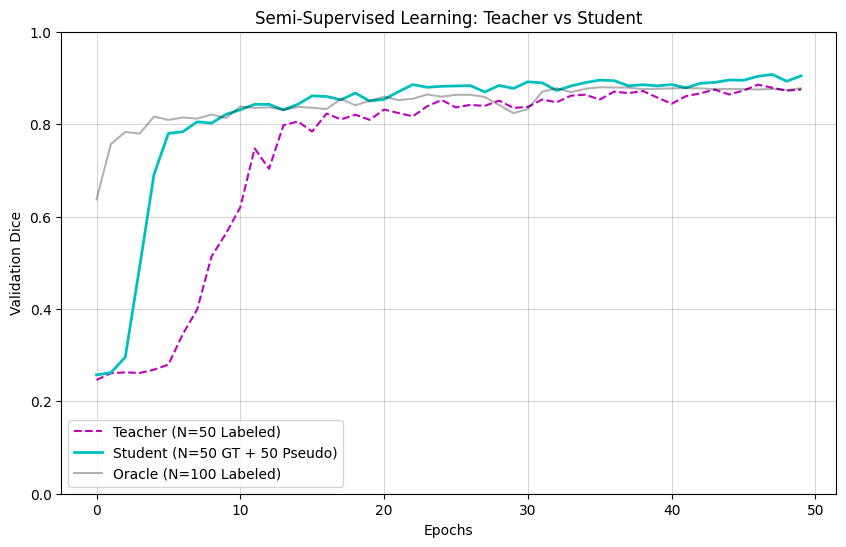

In [14]:
plt.figure(figsize=(10, 6))

# Teacher
plt.plot(teacher_dices, label=f'Teacher (N={n_labeled} Labeled)', color='m', linestyle='--')

# Student
plt.plot(student_dices, label=f'Student (N={n_labeled} GT + {n_unlabeled} Pseudo)', color='c', linewidth=2)

# Oracle Baseline (if available from previous steps)
if 'results_aug' in globals() and 100 in results_aug:
     plt.plot(results_aug[100], label='Oracle (N=100 Labeled)', color='k', alpha=0.3)
elif 'results_no_aug' in globals() and 100 in results_no_aug:
     plt.plot(results_no_aug[100], label='Oracle (N=100 Labeled)', color='k', alpha=0.3)

plt.title("Semi-Supervised Learning: Teacher vs Student")
plt.xlabel("Epochs")
plt.ylabel("Validation Dice")
plt.legend()
plt.grid(True, alpha=0.5)
plt.ylim(0, 1.0)
plt.show()